In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torch_pconv import PConv2d  # Partial convolution layer; ensure this is installed.

In [2]:
class ImageInpaintingDatasetCSV(Dataset):
    """
    Loads images based on a CSV file with two columns:
      - Column 0: path to the color image.
      - Column 1: path to the depth image.
    
    For each sample:
      - Both color and depth images are loaded, resized to img_size, and normalized to [0,1].
      - A square mask (of size mask_size) is randomly applied:
          • For the color image, the masked region is set to 0.
          • For the depth image, the masked region is set to 0.
      - The **input** is built by concatenating the masked color image (3 channels) and the masked depth image (1 channel) → (4, H, W).
      - The **target** is only the original color image (3 channels).
      - The mask is returned as a (1, H, W) tensor with 1 for unmasked and 0 for masked regions.
    """
    def __init__(self, csv_file, img_size=(240,320), mask_size=(64,64), transform=None, apply_mask=True):
        self.data = pd.read_csv(csv_file, header=None)  # Adjust header if needed.
        self.color_paths = self.data.iloc[:, 0].tolist()
        self.depth_paths = self.data.iloc[:, 1].tolist()
        self.img_size = img_size
        self.mask_size = mask_size
        self.transform = transform
        self.apply_mask = apply_mask

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        color_path = self.color_paths[idx]
        depth_path = self.depth_paths[idx]
        # Adjust paths if needed; here we assume CSV paths are relative.
        color_path = os.path.join("../nyu_data/", color_path)
        depth_path = os.path.join("../nyu_data/", depth_path)
        
        # Load color image.
        img = cv2.imread(color_path)
        if img is None:
            raise ValueError(f"Color image not found: {color_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]))
        img = img.astype(np.float32) / 255.0
        
        # Load depth image (grayscale).
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        if depth is None:
            raise ValueError(f"Depth image not found: {depth_path}")
        depth = cv2.resize(depth, (self.img_size[1], self.img_size[0]))
        depth = depth.astype(np.float32) / 255.0
        
        H, W, _ = img.shape
        
        if self.apply_mask:
            mask = self.create_square_mask((H, W), self.mask_size)  # 0 for masked, 255 for unmasked.
            masked_img = img.copy()
            masked_depth = depth.copy()
            mask_3d = np.stack([mask] * 3, axis=-1)
            masked_img[mask_3d == 0] = 0.0
            masked_depth[mask == 0] = 0.0
        else:
            mask = np.ones((H, W), dtype=np.uint8) * 255
            masked_img = img
            masked_depth = depth
        
        # Convert to torch tensors.
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)       # (3, H, W)
        depth_tensor = torch.from_numpy(depth).unsqueeze(0)         # (1, H, W)
        masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1)  # (3, H, W)
        masked_depth_tensor = torch.from_numpy(masked_depth).unsqueeze(0)  # (1, H, W)
        mask_tensor = torch.from_numpy(mask.astype(np.float32) / 255.0).unsqueeze(0)  # (1, H, W)
        
        # Create combined input: [masked color (3 ch) + masked depth (1 ch)] → (4, H, W)
        combined_input = torch.cat([masked_img_tensor, masked_depth_tensor], dim=0)
        # Target is only the original color image.
        target = img_tensor
        
        if self.transform:
            combined_input = self.transform(combined_input)
            target = self.transform(target)
            mask_tensor = self.transform(mask_tensor)
        
        return {
            "combined_input": combined_input,
            "target": target,
            "mask": mask_tensor
        }
    
    def create_square_mask(self, image_size, mask_size):
        H, W = image_size
        mH, mW = mask_size
        mask = np.ones((H, W), dtype=np.uint8) * 255
        top = np.random.randint(0, H - mH + 1)
        left = np.random.randint(0, W - mW + 1)
        mask[top:top+mH, left:left+mW] = 0
        return mask

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(EncoderBlock, self).__init__()
        self.pconv1 = PConv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=1, padding=padding, bias=True)
        self.pconv2 = PConv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=2, padding=padding, bias=True)
    
    def forward(self, x, mask):
        if mask.dim() == 4 and mask.size(1)==1:
            mask = mask.squeeze(1)
        x1, mask1 = self.pconv1(x, mask)
        x1 = F.relu(x1)
        x2, mask2 = self.pconv2(x1, mask1)
        x2 = F.relu(x2)
        return x1, mask1, x2, mask2

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels1, out_channels2, kernel_size=3, padding=1):
        super(DecoderBlock, self).__init__()
        self.pconv1 = PConv2d(skip_channels + in_channels, out_channels1, kernel_size=kernel_size,
                              stride=1, padding=padding, bias=True)
        self.pconv2 = PConv2d(out_channels1, out_channels2, kernel_size=kernel_size,
                              stride=1, padding=padding, bias=True)
    
    def forward(self, x, mask, skip_x, skip_mask):
        x_up = F.interpolate(x, scale_factor=2, mode='nearest')
        if mask.dim() == 4 and mask.size(1)==1:
            mask = mask.squeeze(1)
        mask_up = F.interpolate(mask.unsqueeze(1), scale_factor=2, mode='nearest').squeeze(1)
        if skip_mask.dim() == 4 and skip_mask.size(1)==1:
            skip_mask = skip_mask.squeeze(1)
        mask_cat = torch.max(skip_mask, mask_up)
        x_cat = torch.cat([skip_x, x_up], dim=1)
        x1, mask1 = self.pconv1(x_cat, mask_cat)
        x1 = F.relu(x1)
        x2, mask2 = self.pconv2(x1, mask1)
        x2 = F.relu(x2)
        return x1, mask1, x2, mask2

class InpaintingModelWithDepthBypass(nn.Module):
    def __init__(self, output_channels=3):
        """
        This model takes a 4-channel input:
          - Channels 0-2: masked RGB image.
          - Channel 3: masked depth image.
        It processes the RGB image through a U-Net branch and uses a bypass branch to process the depth input.
        Their outputs are fused via a 1×1 convolution to produce the final 3-channel RGB output.
        """
        super(InpaintingModelWithDepthBypass, self).__init__()
        # RGB branch (U-Net inpainting).
        self.rgb_enc1 = EncoderBlock(3, 8)
        self.rgb_enc2 = EncoderBlock(8, 16)
        self.rgb_enc3 = EncoderBlock(16, 32)
        self.rgb_enc4 = EncoderBlock(32, 64)

        self.rgb_dec1 = DecoderBlock(64, 64, 64, 32)
        self.rgb_dec2 = DecoderBlock(32, 32, 32, 16)
        self.rgb_dec3 = DecoderBlock(16, 16, 16, 8)
        self.rgb_dec4 = DecoderBlock(8, 8, 8, 3)
        self.rgb_final = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        
        # Depth bypass branch: lightweight processing using 1×1 convolutions.
        self.depth_conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.depth_relu = nn.ReLU()
        self.depth_conv2 = nn.Conv2d(4, 1, kernel_size=3, padding=1)
        
        # Fusion: concatenate the RGB branch output (3 channels) with the depth bypass output (1 channel)
        # and fuse them via a 1×1 convolution to produce the final 3-channel RGB output.
        self.fusion_conv = nn.Conv2d(3 + 1, output_channels, kernel_size=1)
    
    def forward(self, x, mask):
        # x: (B, 4, H, W); channels 0-2 are RGB, channel 3 is depth.
        rgb_in = x[:, :3, :, :]
        depth_in = x[:, 3:, :, :]
        
        # RGB branch.
        conv1, m1, conv2, m2 = self.rgb_enc1(rgb_in, mask)
        conv3, m3, conv4, m4 = self.rgb_enc2(conv2, m2)
        conv5, m5, conv6, m6 = self.rgb_enc3(conv4, m4)
        conv7, m7, conv8, m8 = self.rgb_enc4(conv6, m6)
        
        dec1, dm1, dec1_out, dm1_2 = self.rgb_dec1(conv8, m8, conv7, m7)
        dec2, dm2, dec2_out, dm2_2 = self.rgb_dec2(dec1_out, dm1_2, conv5, m5)
        dec3, dm3, dec3_out, dm3_2 = self.rgb_dec3(dec2_out, dm2_2, conv3, m3)
        dec4, dm4, dec4_out, dm4_2 = self.rgb_dec4(dec3_out, dm3_2, conv1, m1)
        rgb_out = self.rgb_final(dec4_out)
        rgb_out = torch.sigmoid(rgb_out)
        
        # Depth bypass branch.
        depth_out = self.depth_conv1(depth_in)
        depth_out = self.depth_relu(depth_out)
        depth_out = self.depth_conv2(depth_out)
        depth_out = torch.sigmoid(depth_out)
        
        # Fusion.
        combined = torch.cat([rgb_out, depth_out], dim=1)  # (B, 3+1, H, W)
        output = self.fusion_conv(combined)                # (B, 3, H, W)
        output = torch.sigmoid(output)
        return output

In [4]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + epsilon) / (y_true_f.sum() + y_pred_f.sum() + epsilon)

In [5]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch in tqdm(dataloader):
        combined_input = batch["combined_input"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)  # target is the original color image (3 channels)
        
        optimizer.zero_grad()
        output = model(combined_input, mask)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * combined_input.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_dice = 0.0
    with torch.no_grad():
        for batch in dataloader:
            combined_input = batch["combined_input"].to(device)
            mask = batch["mask"].to(device)
            target = batch["target"].to(device)
            output = model(combined_input, mask)
            loss = criterion(output, target)
            running_loss += loss.item() * combined_input.size(0)
            total_dice += dice_coef(target, output).item() * combined_input.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_dice = total_dice / len(dataloader.dataset)
    return epoch_loss, epoch_dice

In [6]:
train_csv = r"/Users/jinhyunpark/Desktop/CSCE748_Computational-Photography/nyu_data/data/nyu2_train.csv"
test_csv  = r"/Users/jinhyunpark/Desktop/CSCE748_Computational-Photography/nyu_data/data/nyu2_test.csv"

full_train_dataset = ImageInpaintingDatasetCSV(train_csv, img_size=(240,320), mask_size=(64,64), apply_mask=True)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataset = ImageInpaintingDatasetCSV(test_csv, img_size=(240,320), mask_size=(64,64), apply_mask=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 40550
Val samples: 10138
Test samples: 654


In [7]:
def show_sample(sample_dict, idx=0):
    # Convert Torch tensors -> NumPy, shape (H, W, C). Tensor, shape (C, H, W)
    combined_input_np = sample_dict["combined_input"][idx].permute(1, 2, 0).cpu().numpy()
    target_np = sample_dict["target"][idx].permute(1, 2, 0).cpu().numpy()
    mask_np = sample_dict["mask"][idx].squeeze(0).cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].imshow(combined_input_np)
    axs[0].set_title("Combined input: Image + Depth")

    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title("Random Mask")

    axs[2].imshow(target_np)
    axs[2].set_title("Target: Image")

    plt.tight_layout()
    plt.show()

torch.Size([16, 4, 240, 320])
torch.Size([16, 3, 240, 320])
torch.Size([16, 1, 240, 320])


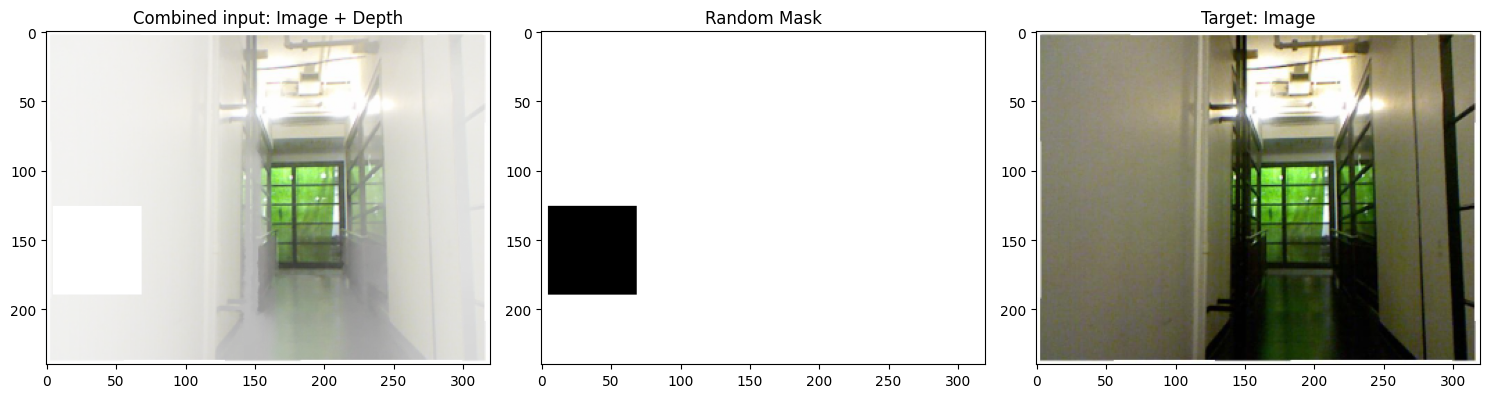

In [8]:
sample_batch = next(iter(train_loader))

print(sample_batch["combined_input"].shape)     # Should be (batch_size, 4, H, W)
print(sample_batch["target"].shape)             # Should be (batch_size, 3, H, W)
print(sample_batch["mask"].shape)               # Should be (batch_size, 1, H, W) 

# Visualize first sample in the batch
show_sample(sample_batch, idx=0)

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = InpaintingModelWithDepthBypass(output_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

num_epochs = 20
best_val_loss = float('inf')
for epoch in range(1, num_epochs+1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_inpainting_depth_model_v3.pth")
        print(f"Saved best model with Val Loss: {best_val_loss:.4f}")

mps


/Users/jinhyunpark/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2535/2535 [07:39<00:00,  5.52it/s]


Epoch 1/20 - Train Loss: 0.2453 | Val Loss: 0.2424 | Val Dice: 0.4263
Saved best model with Val Loss: 0.2424


100%|██████████| 2535/2535 [07:37<00:00,  5.55it/s]


Epoch 2/20 - Train Loss: 0.2430 | Val Loss: 0.2421 | Val Dice: 0.4259
Saved best model with Val Loss: 0.2421


100%|██████████| 2535/2535 [07:43<00:00,  5.47it/s]


Epoch 3/20 - Train Loss: 0.2424 | Val Loss: 0.2398 | Val Dice: 0.4334
Saved best model with Val Loss: 0.2398


100%|██████████| 2535/2535 [07:45<00:00,  5.45it/s]


Epoch 4/20 - Train Loss: 0.2398 | Val Loss: 0.2384 | Val Dice: 0.4253
Saved best model with Val Loss: 0.2384


100%|██████████| 2535/2535 [07:44<00:00,  5.46it/s]


Epoch 5/20 - Train Loss: 0.2384 | Val Loss: 0.2371 | Val Dice: 0.4396
Saved best model with Val Loss: 0.2371


100%|██████████| 2535/2535 [07:45<00:00,  5.44it/s]


Epoch 6/20 - Train Loss: 0.2373 | Val Loss: 0.2360 | Val Dice: 0.4403
Saved best model with Val Loss: 0.2360


100%|██████████| 2535/2535 [07:46<00:00,  5.44it/s]


Epoch 7/20 - Train Loss: 0.2364 | Val Loss: 0.2351 | Val Dice: 0.4366
Saved best model with Val Loss: 0.2351


100%|██████████| 2535/2535 [07:44<00:00,  5.45it/s]


Epoch 8/20 - Train Loss: 0.2357 | Val Loss: 0.2343 | Val Dice: 0.4365
Saved best model with Val Loss: 0.2343


100%|██████████| 2535/2535 [07:45<00:00,  5.44it/s]


Epoch 9/20 - Train Loss: 0.2349 | Val Loss: 0.2336 | Val Dice: 0.4350
Saved best model with Val Loss: 0.2336


100%|██████████| 2535/2535 [07:47<00:00,  5.43it/s]


Epoch 10/20 - Train Loss: 0.2340 | Val Loss: 0.2330 | Val Dice: 0.4331
Saved best model with Val Loss: 0.2330


100%|██████████| 2535/2535 [07:47<00:00,  5.43it/s]


Epoch 11/20 - Train Loss: 0.2331 | Val Loss: 0.2328 | Val Dice: 0.4314
Saved best model with Val Loss: 0.2328


100%|██████████| 2535/2535 [07:47<00:00,  5.43it/s]


Epoch 12/20 - Train Loss: 0.2324 | Val Loss: 0.2311 | Val Dice: 0.4461
Saved best model with Val Loss: 0.2311


100%|██████████| 2535/2535 [07:47<00:00,  5.43it/s]


Epoch 13/20 - Train Loss: 0.2319 | Val Loss: 0.2306 | Val Dice: 0.4473
Saved best model with Val Loss: 0.2306


100%|██████████| 2535/2535 [07:47<00:00,  5.43it/s]


Epoch 14/20 - Train Loss: 0.2324 | Val Loss: 0.2317 | Val Dice: 0.4544


100%|██████████| 2535/2535 [07:47<00:00,  5.43it/s]


Epoch 15/20 - Train Loss: 0.2321 | Val Loss: 0.2322 | Val Dice: 0.4601


100%|██████████| 2535/2535 [07:46<00:00,  5.43it/s]


Epoch 16/20 - Train Loss: 0.2317 | Val Loss: 0.2304 | Val Dice: 0.4465
Saved best model with Val Loss: 0.2304


100%|██████████| 2535/2535 [07:46<00:00,  5.43it/s]


Epoch 17/20 - Train Loss: 0.2314 | Val Loss: 0.2304 | Val Dice: 0.4551


100%|██████████| 2535/2535 [07:46<00:00,  5.44it/s]


Epoch 18/20 - Train Loss: 0.2312 | Val Loss: 0.2302 | Val Dice: 0.4540
Saved best model with Val Loss: 0.2302


100%|██████████| 2535/2535 [07:46<00:00,  5.43it/s]


Epoch 19/20 - Train Loss: 0.2310 | Val Loss: 0.2302 | Val Dice: 0.4437


100%|██████████| 2535/2535 [07:46<00:00,  5.43it/s]


Epoch 20/20 - Train Loss: 0.2308 | Val Loss: 0.2298 | Val Dice: 0.4458
Saved best model with Val Loss: 0.2298


mps
SSD between Inpainted vs GT: 76342.56
SSD between Masked vs GT: 2061.6343
SSD between Inpainted vs GT: 54445.1
SSD between Masked vs GT: 4282.089
SSD between Inpainted vs GT: 59318.844
SSD between Masked vs GT: 3824.3147


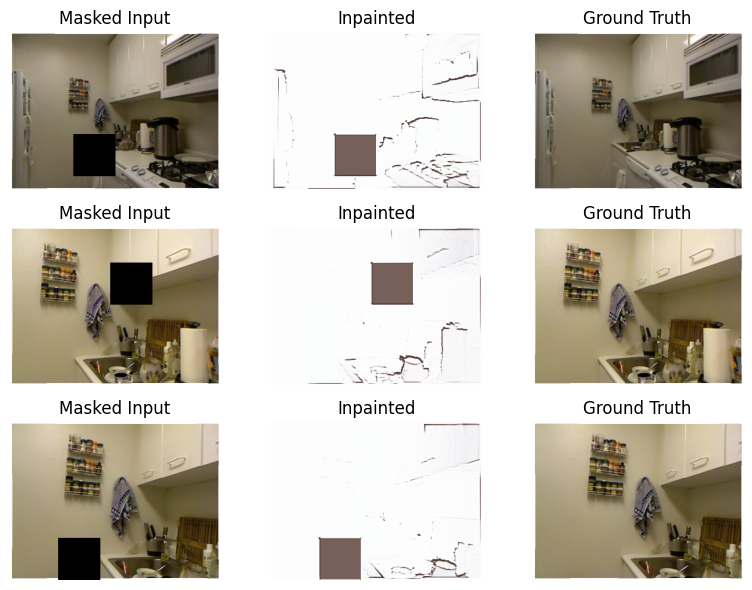

In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = InpaintingModelWithDepthBypass(output_channels=3).to(device)
model.load_state_dict(torch.load("best_inpainting_depth_model_v3.pth", map_location=device))
model.eval()

# Visualization: select a few samples from the test dataset.
sample_idx = 54
rows = 3
samples = [test_dataset[i] for i in range(sample_idx, sample_idx + rows)]
masked_images = torch.stack([s["combined_input"] for s in samples], dim=0)
masks = torch.stack([s["mask"] for s in samples], dim=0)
sample_labels = torch.stack([s["target"] for s in samples], dim=0)

inpainted_images = []
with torch.no_grad():
    for i in range(rows):
        input_masked = masked_images[i].unsqueeze(0).to(device)
        input_mask = masks[i].unsqueeze(0).to(device)
        pred = model(input_masked, input_mask)
        inpainted_images.append(pred.squeeze(0).cpu())

# For visualization, we'll display 3 columns: Masked Input (RGB part), Inpainted Output, and Ground Truth.
fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(8, 2*rows))
for i in range(rows):
    # Show only the RGB part (channels 0-2).
    masked_np = masked_images[i][:3].permute(1, 2, 0).cpu().numpy()
    inpainted_np = inpainted_images[i][:3].permute(1, 2, 0).cpu().numpy()
    label_np = sample_labels[i][:3].permute(1, 2, 0).cpu().numpy()
    
    # Compute SSD over the masked region using the mask for evaluation.
    mask_np = masks[i].squeeze(0).cpu().numpy()  # shape: (H, W)
    print("SSD between Inpainted vs GT:", np.sum((inpainted_np - label_np)**2))
    print("SSD between Masked vs GT:", np.sum((masked_np - label_np)**2))
    
    axs[i, 0].imshow(masked_np)
    axs[i, 0].set_title("Masked Input")
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(inpainted_np)
    axs[i, 1].set_title("Inpainted")
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(label_np)
    axs[i, 2].set_title("Ground Truth")
    axs[i, 2].axis("off")
    
plt.tight_layout()
plt.show()